In [1]:
import os
import glob
import skimage
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class CellsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cells"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE =33

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = CellsConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cells
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING     

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class CellsDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_cells(self, mode):
        
        self.add_class("cells", 1, "round")
        with open("/home/mshi/Mask_RCNN/myData/train/listTrain.txt", "r") as lis:
            indx=0
            for item in lis:
                item=item.rstrip('\n')
                if mode=="train":
                    if indx<500:
                        self.add_image("cells", image_id=indx, path="/home/mshi/Mask_RCNN/myData/train/"+item+"/images/"+item+'.png')
                else:
                    if indx>=500:
                        self.add_image("cells", image_id=indx, path="/home/mshi/Mask_RCNN/myData/train/"+item+"/images/"+item+'.png')
                    
                indx+=1
    def add_image(self, source, image_id, path, **kwargs):
        image_info = {
            "id": image_id,
            "source": source,
            "path": path,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)
        
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        if image.shape[2]==4:
             image=skimage.color.rgba2rgb(image)
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image
    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. Override this
        method to load instance masks and return them in the form of am
        array of binary masks of shape [height, width, instances].
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # Override this function to load a mask from your dataset.
        # Otherwise, it returns an empty mask.
        #get all masks in a folder associated with image_id lis=['~/..bla/image_id/masks/file1.png', '.../file2.png', ...]
        whichImage=self.image_info[image_id]['path'].split('/')[6]
        
        os.chdir("/home/mshi/Mask_RCNN/myData/train/"+whichImage+'/masks/')
        
        masks=   np.stack([skimage.io.imread(file) for file in glob.glob("*.png")], axis=-1)
       
        class_ids=np.ones(masks.shape[2], dtype=np.int32)
        
        
        return masks, class_ids

In [5]:
dataset_train = CellsDataset()
dataset_train.load_cells('train')
dataset_train.prepare()

dataset_val = CellsDataset()
dataset_val.load_cells('val')
dataset_val.prepare()

In [6]:
dataset_val.image_info

[{'id': 500,
  'path': '/home/mshi/Mask_RCNN/myData/train/bc115ff727e997a88f7cfe4ce817745731a6c753cb9fab6a36e7e66b415a1d3d/images/bc115ff727e997a88f7cfe4ce817745731a6c753cb9fab6a36e7e66b415a1d3d.png',
  'source': 'cells'},
 {'id': 501,
  'path': '/home/mshi/Mask_RCNN/myData/train/bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b/images/bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b.png',
  'source': 'cells'},
 {'id': 502,
  'path': '/home/mshi/Mask_RCNN/myData/train/be1916d0e5592c17f971315b5de720ef6894173087399daed94a52ef109c1572/images/be1916d0e5592c17f971315b5de720ef6894173087399daed94a52ef109c1572.png',
  'source': 'cells'},
 {'id': 503,
  'path': '/home/mshi/Mask_RCNN/myData/train/be26966900aa0e5b41d5a8ecafe04281b37deb05c5cd027968d7b74143398174/images/be26966900aa0e5b41d5a8ecafe04281b37deb05c5cd027968d7b74143398174.png',
  'source': 'cells'},
 {'id': 504,
  'path': '/home/mshi/Mask_RCNN/myData/train/be771d6831e3f8f1af4696bc08a582f163735db5baf9906e47

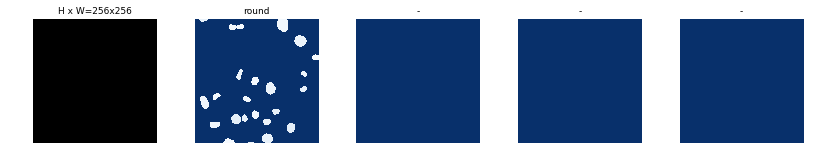

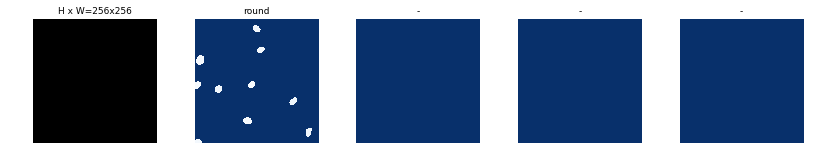

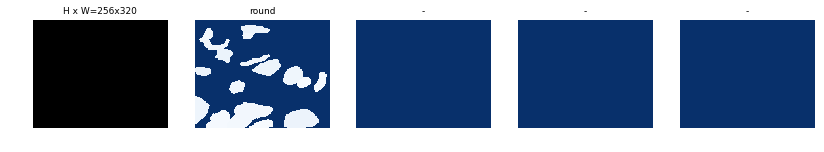

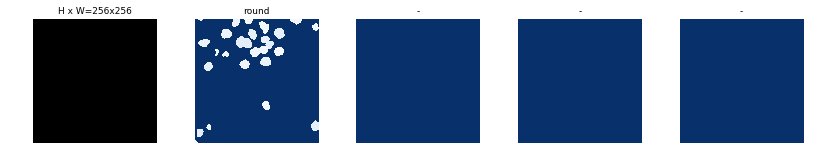

In [7]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


In [8]:
image

array([[[0.03137255, 0.03137255, 0.03137255],
        [0.04313725, 0.04313725, 0.04313725],
        [0.05882353, 0.05882353, 0.05882353],
        ...,
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941]],

       [[0.03529412, 0.03529412, 0.03529412],
        [0.03529412, 0.03529412, 0.03529412],
        [0.05098039, 0.05098039, 0.05098039],
        ...,
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941]],

       [[0.03137255, 0.03137255, 0.03137255],
        [0.03529412, 0.03529412, 0.03529412],
        [0.04313725, 0.04313725, 0.04313725],
        ...,
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941]],

       ...,

       [[0.14901961, 0.14901961, 0.14901961],
        [0.14901961, 0.14901961, 0.14901961],
        [0.12941176, 0

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [11]:
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.


In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10,
            epochs=100, 
            layers='all')

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNorm)
res3a_branch2c         (Conv2D)
res3a_branch1          (Conv2D)
bn3a_branch2c          (BatchNorm)
bn3a

/home/mshi/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
100/100 [==============================] - 179s 2s/step - loss: 2.9500 - rpn_class_loss: 0.7843 - rpn_bbox_loss: 0.9251 - mrcnn_class_loss: 0.2846 - mrcnn_bbox_loss: 0.5051 - mrcnn_mask_loss: 0.4508 - val_loss: 2.7049 - val_rpn_class_loss: 0.2700 - val_rpn_bbox_loss: 0.7251 - val_mrcnn_class_loss: 0.5446 - val_mrcnn_bbox_loss: 0.4950 - val_mrcnn_mask_loss: 0.6702
Epoch 2/100
 42/100 [===========>..................] - ETA: 1:29 - loss: 2.6191 - rpn_class_loss: 0.3179 - rpn_bbox_loss: 0.7775 - mrcnn_class_loss: 0.3933 - mrcnn_bbox_loss: 0.5275 - mrcnn_mask_loss: 0.6031

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_cells.h5")
model.keras_model.save_weights(model_path)
print(model_path)

In [ ]:
class InferenceConfig(CellsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
print(model_path)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights('/home/mshi/Mask_RCNN/logs/mask_rcnn_cells.h5', by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))